<a href="https://colab.research.google.com/github/justincobelens/learning_pytorch/blob/main/01_pytorch_workflow_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import torch
from torch import nn # nn contains all of PyTorch's bulding blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np

torch.__version__

'1.13.1+cu116'

1. data (prepare and load)
2. build model
3. fitting the model to data (training)
4. makingg predictions and evaluate a model (inference
5. saving and loading a model
6. putting it all together

## 1. Data (preparing and loading)

* Excel spreadsheet
* Images of any kind
* Videos (YouTube)
* Audio (songs or podcasts)
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this, create some *known* data using the linear regression formula.

Use a linear regression formula to make a straight line with *known* **parameters**.

 `Y = aX + b`

In [2]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets (one of t he most important concepts in ML in general)


Create a training and test set with the data

In [4]:
from IPython.utils.tempdir import TemporaryWorkingDirectory
# Create a train/sest split

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)  # data, label

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data=X_train,
                      train_labels=y_train,
                      test_data=X_test,
                      test_labels=y_test,
                      predictions=None):
  """
  Plots training data, test data and compares predictions
  """

  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});


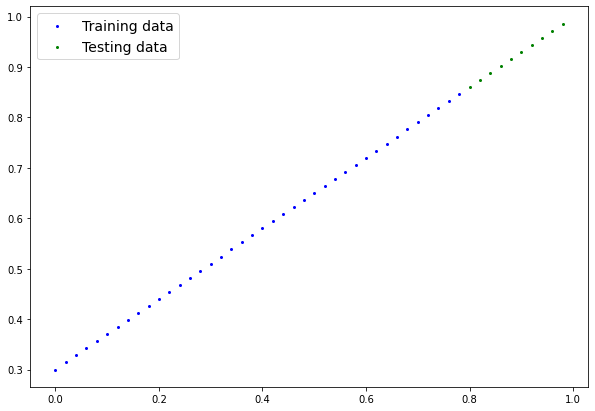

In [6]:
plot_predictions()

## 2. Build model

What the model does:
* Start with random values (weight * bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values used to create the data)

How does it do so?

Through 2 main algorithms: (Applied Numerical Analysis and Computational modelling courses for reference)
1. Gradient descent 
2. Backpropogation


In [7]:
# Create linear regression model class
# https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
class LinearRegressionModel(nn.Module): # <- Base class for all neural network modules
  def __init__(self):
    super().__init__()
    
    # Initialize model parameters
    self.weights = nn.Parameter(torch.randn(1,  # <- start with a random weight and try to adjust it to the ideal weight
                                            requires_grad=True, # PyTorch will track the gradients, default; requires_grad=True
                                            dtype=torch.float)) # default dtype=torch.float)
   
    self.bias = nn.Parameter(torch.randn(1, 
                                        requires_grad=True,
                                        dtype=torch.float))
    
  # forward() defines the computation in the model
  def forward(self, x: torch.Tensor) ->torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias # Linear regression formula y = aX + b





### PyTorch model buildling essentials

* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* torch.Parameter - what parameters should the model try and learn, often a PyTorch layer from torch.nn will set these
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happesn in the forward computation

### Checking the contents of the PyTorch model

To see what in inside the model parameters or whats inside the model use `.parameters()`.

In [29]:

def refresh_model():
  # Create a random seed
  torch.manual_seed(42)

  # Create an instance of the model 
  model_0 = LinearRegressionModel()

  # Check the parameters
  # list(model_0.parameters())
  
  return model_0

model_0 = refresh_model()

In [30]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check the model's predictive power, let's see how well its predicts `y_test` based on `X_test`.

When data is passed th rough the model, it's going to run it through the forward() method

In [ ]:
# Make predictions with model
with torch.inference_mode(): # inference mode tracks less, makes code faster, torch.no_grad() is kinda similar
  y_preds = model_0(X_test)

y_preds

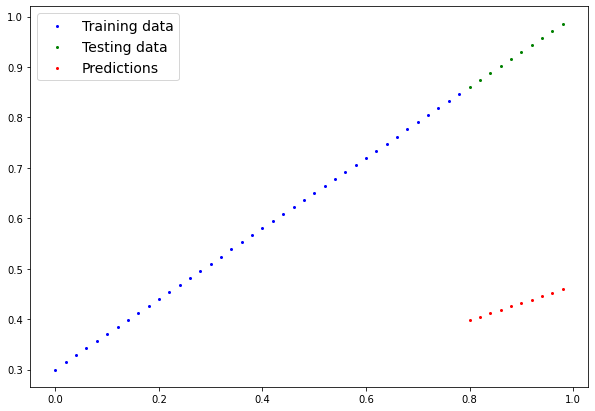

In [11]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters.

Or in other words from a poor representation of the data to a better representation of the data

One way to measure how poor or how wrong your models predictions are is to use a loss function.

* Note: Loss function may also be calles cost function or criterion in differenrt areas. For this case, it will be refer to as a loss function

Things needed to train:

* **Loss function:** A function to measure how wrong the model's prediction are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias) to improve the loss function. 
  * Inside the optimizer you'll often set two parameters
    * `params` - the model parameters you'd like to optimize
    * `lr` (learning rate) - the learning rate is a hyperparameter that defines how big/small the optimizer changes the parameter

And specifically for PyTorch:
* A training loop
* A testing loop

In [12]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [13]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [48]:
model_0 = refresh_model()

# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                         lr=0.01) # lr = learning rate = possible the most imporant hyperparameter

### Building a training loop (and a testing loop) in PyTorch

Things needed in a training loop:
0. Loop through the data
1. Forward pass (this involes data moving through the model's `forward()` functions) to m ake predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [49]:
# An epoch is one loop through the data... (this is a hyperparameter, because it is set)
epochs = 200


# Track different values
epoch_count = []
train_loss_values = []
test_loss_values = []


### Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad, basically starting a fresh optimizer
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will acculumate through the loop, so they have to zero them above in step 3 for the next iteration of the loop


  ### Testing
  model_0.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers)
  with torch.inference_mode(): # turns off gradient tracket & couple more things
    # 1. Forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    train_loss_values.append(loss)
    test_loss_values.append(test_loss)
    #print(f"Epoch: {epoch} | MAE Train Loss: {loss} | Test loss: {test_loss}")

    # Print out model state_dict()
    #print(model_0.state_dict())

    #print()

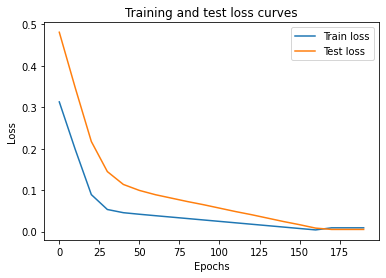

In [36]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(train_loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [50]:
weight, bias, model_0.state_dict()

(0.7,
 0.3,
 OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))]))

In [27]:
# Make predictions with model
with torch.inference_mode(): # inference mode tracks less, makes code faster, torch.no_grad() is kinda similar
  y_preds = model_0(X_test)

y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

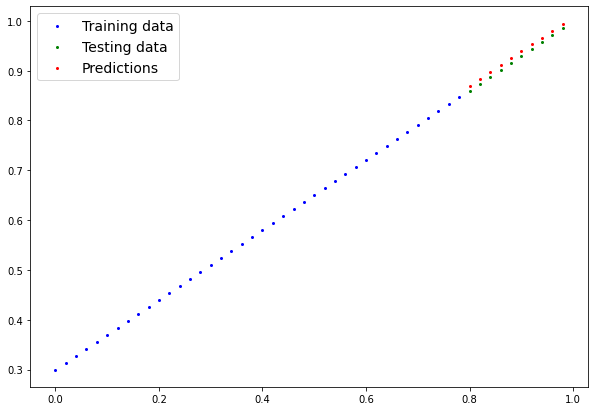

In [28]:
plot_predictions(predictions=y_preds)

## 4. Svaing a model in PyTorch

Three main methods for saving and loading models in PyTorch.

1. `torch.save()` - allows to save a PyTorch object in pickle format.
2. `torch.load()` - allows to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - allows to load a model's saved state dictionary


https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [90]:
# Saving PyTorch model
from pathlib import Path

# 1. Create models dir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


## 5. Load a model in PyTorch

Since the model's `state_dict` is saved rather the entire model, a new instance of the model class is created and load the saved `state_dict` into that.

In [54]:
# To load a saved state_dict, instantiate a new instance of the model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [55]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [57]:
# Make some predictions with loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [58]:
# Compare loaded model preds with original model preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

In [59]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy
from pathlib import Path

torch.__version__

'1.13.1+cu116'

Create device-agnostic code.

This means if there is acces to a GPU, the code will us it (for potentially faster computerin).

If no GPU is available, the code will default to using CPU.

In [61]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### 6.1 Data

# New Section

In [63]:
# Create some data. using the linear regression formula of y = weight * X + bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # w/o unsqueeze, errors will pop up
y = weight * X + bias

# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [67]:
# Plot the data
def plot_predictions(train_data=X_train,
                      train_labels=y_train,
                      test_data=X_test,
                      test_labels=y_test,
                      predictions=None):
  """
  Plots training data, test data and compares predictions
  """

  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

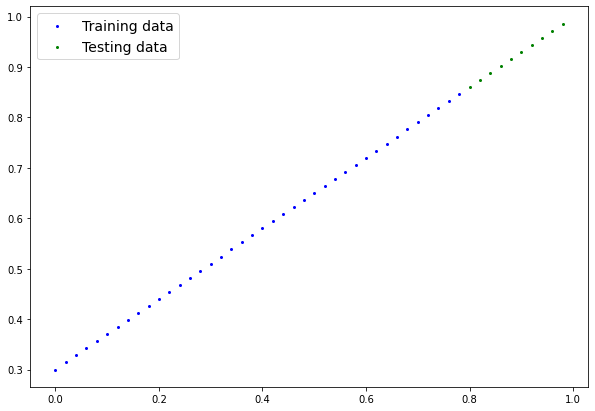

In [68]:
plot_predictions(X_train, y_train, X_test, y_test)

## 6.2 Building a PyTorch Linear model

In [73]:
# Create a linear model by subclassing nn.Module

class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters / linear transform, probe layer, fully connected layer, dense layer
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)



  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)


# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
# model_1, model_1.state_dict()

device(type='cuda', index=0)

In [74]:
# Check the model current device
next(model_1.parameters()).device

device(type='cuda', index=0)

In [75]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

## 6.3 Training

For training:
* Loss fn
* Optimizer
* Training Loop
* Testing Loop

In [77]:
# Setup loss function
loss_fn = nn.L1Loss()

# Setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [79]:
# Training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)


for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Opitmizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

  
  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416

In [80]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [81]:
weight, bias

(0.7, 0.3)

In [85]:
# Make predictions with model
model_1.eval()

with torch.inference_mode():
  y_preds = model_1(X_test)

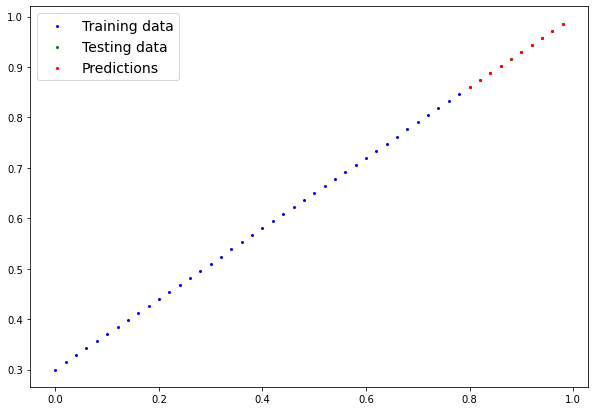

In [89]:
# Plot

plot_predictions(predictions=y_preds.cpu())

### 6.5 Saving & loading a trained model

In [ ]:

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME



In [96]:
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [102]:
print(f"Load model from: {MODEL_SAVE_PATH}")

loaded_model_1 = LinearRegressionModelV2()

loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_1.to(device)

Load model from: models/01_pytorch_workflow_model_1.pth


LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [103]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [104]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [106]:
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')